In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_visualisation

def load_cycles(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def compute_angle(p1, p2, p3):
    """Computes the angle between three points."""
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(dot_product / norm_product) * (180.0 / np.pi)

def extract_angle_series(cycle_data, joint1, joint2, joint3):
    """Extracts time-series data for an angle between three joints from a cycle."""
    angles = []
    for i in range(len(cycle_data[joint1 + "_x"])):
        p1 = (cycle_data[joint1 + "_x"][i], cycle_data[joint1 + "_y"][i])
        p2 = (cycle_data[joint2 + "_x"][i], cycle_data[joint2 + "_y"][i])
        p3 = (cycle_data[joint3 + "_x"][i], cycle_data[joint3 + "_y"][i])
        angles.append(compute_angle(p1, p2, p3))
    return np.array(angles)

def compare_cycles_angles(data, joint_triplets, gear_filter=None, visualize=False):
    """Compares movement cycles for specific joint angles using DTW and optionally visualizes the alignment."""
    dtw_results = {}
    cycles = {k: v for k, v in data.items() if gear_filter is None or v.get("Label") == gear_filter}
    cycle_keys = list(cycles.keys())
    
    for joint1, joint2, joint3 in joint_triplets:
        for i in range(len(cycle_keys)):
            for j in range(i + 1, len(cycle_keys)):
                cycle1 = extract_angle_series(cycles[cycle_keys[i]], joint1, joint2, joint3)
                cycle2 = extract_angle_series(cycles[cycle_keys[j]], joint1, joint2, joint3)
                dist = dtw.distance(cycle1, cycle2)
                path = dtw.warping_path(cycle1, cycle2)
                dtw_results[f"{cycle_keys[i]} vs {cycle_keys[j]} ({joint1}-{joint2}-{joint3})"] = dist
                
                if visualize:
                    plt.figure(figsize=(8, 4))
                    dtw_visualisation.plot_warping(cycle1, cycle2, path, filename=None)
                    plt.title(f"DTW Alignment: {cycle_keys[i]} vs {cycle_keys[j]} ({joint1}-{joint2}-{joint3})")
                    plt.show()
    
    return dtw_results

# Load cycle data
file_path = "../classification/cycle_splits/labeled_data/labeled_cycles_17_cut.json"
data = load_cycles(file_path)

# Define joint triplets for angle comparisons
joint_triplets = [("RHip", "RKnee", "RAnkle"), ("LHip", "LKnee", "LAnkle"), ("RShoulder", "RElbow", "RWrist"), ("LShoulder", "LElbow", "LWrist")]

# Compare angles for cycles within the same gear with visualization
dtw_comparisons = compare_cycles_angles(data, joint_triplets, gear_filter="gear2", visualize=True)

# Print DTW results
for comparison, distance in dtw_comparisons.items():
    print(f"DTW Distance {comparison}: {distance}")


<Figure size 800x400 with 0 Axes>

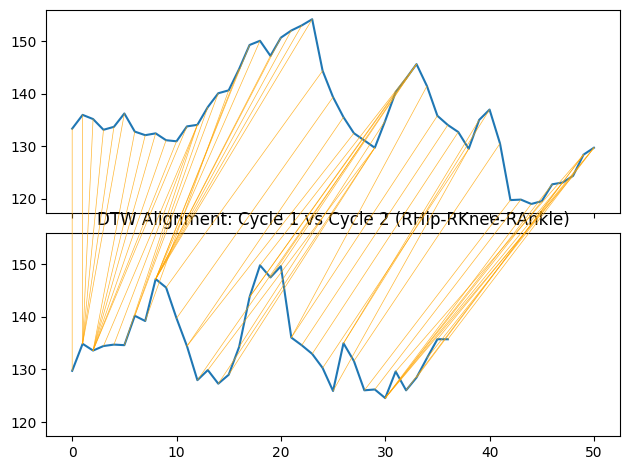

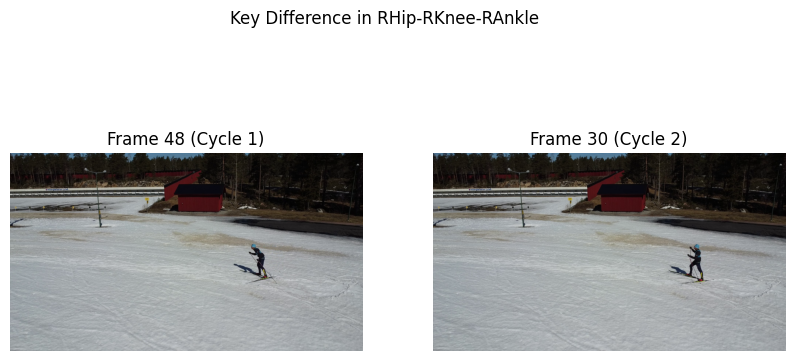

<Figure size 800x400 with 0 Axes>

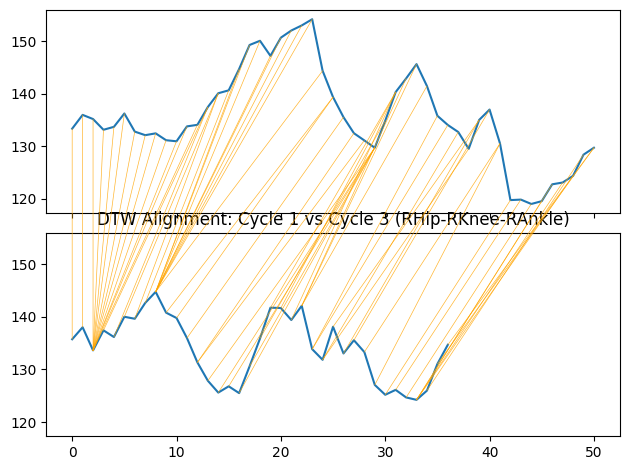

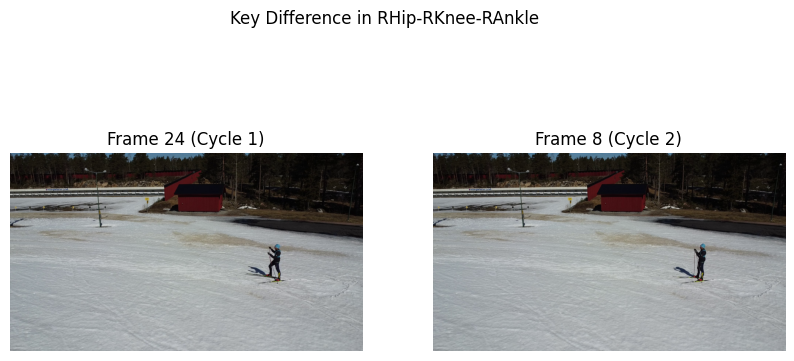

<Figure size 800x400 with 0 Axes>

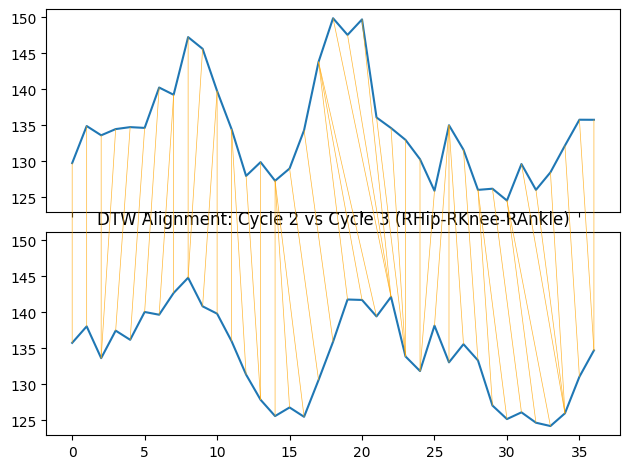

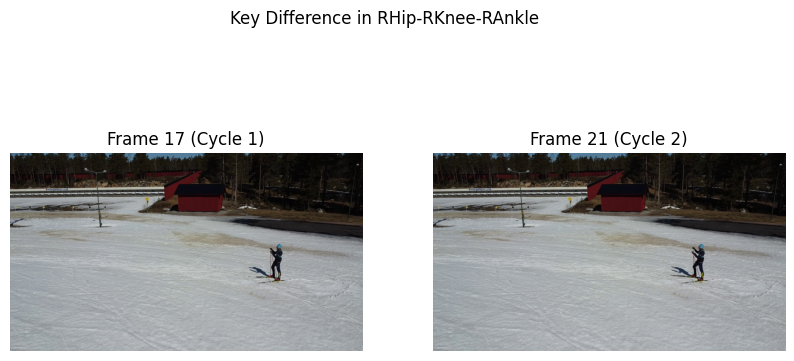

<Figure size 800x400 with 0 Axes>

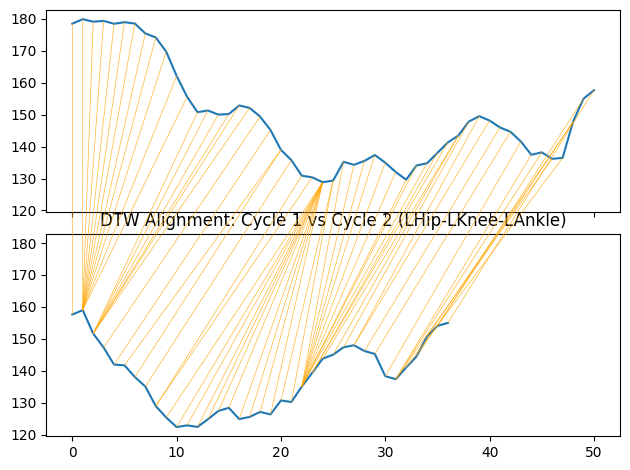

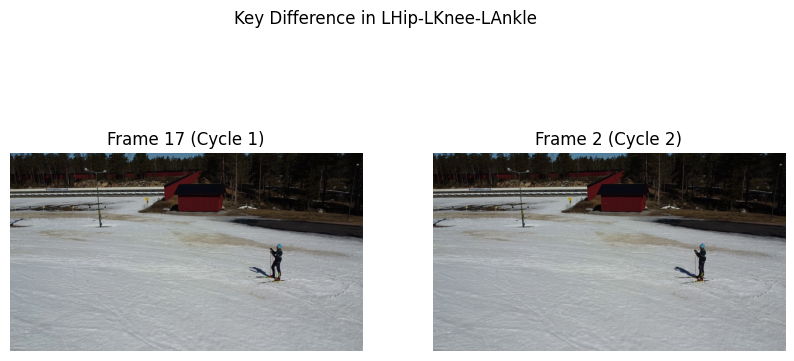

<Figure size 800x400 with 0 Axes>

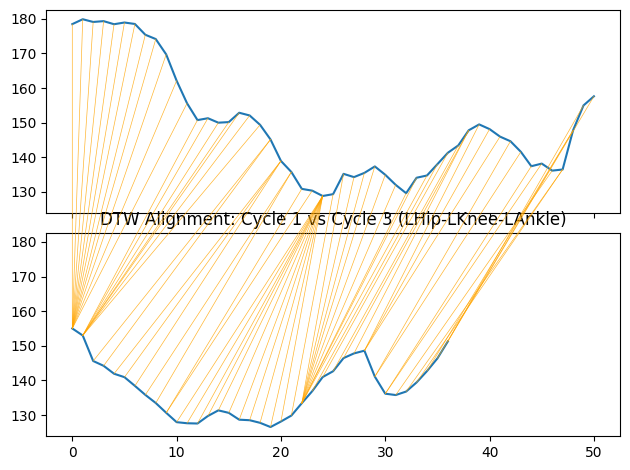

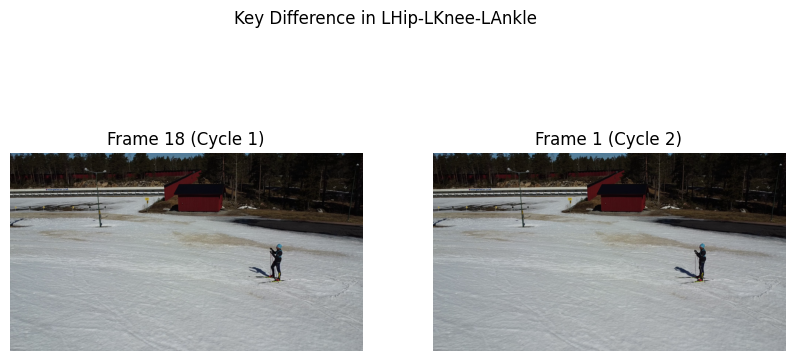

<Figure size 800x400 with 0 Axes>

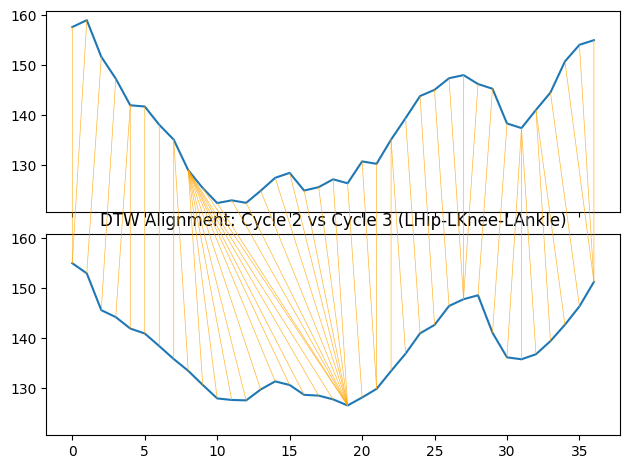

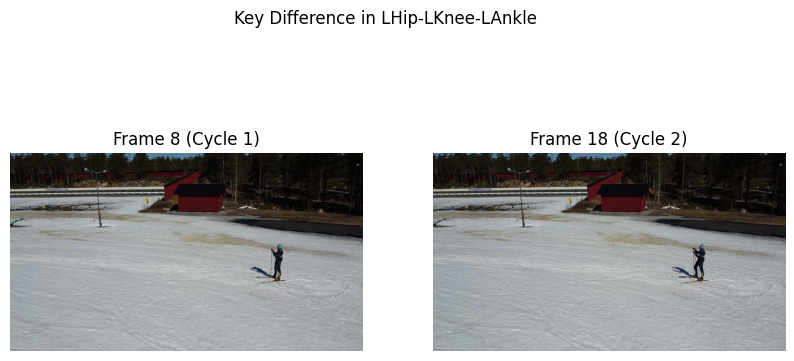

<Figure size 800x400 with 0 Axes>

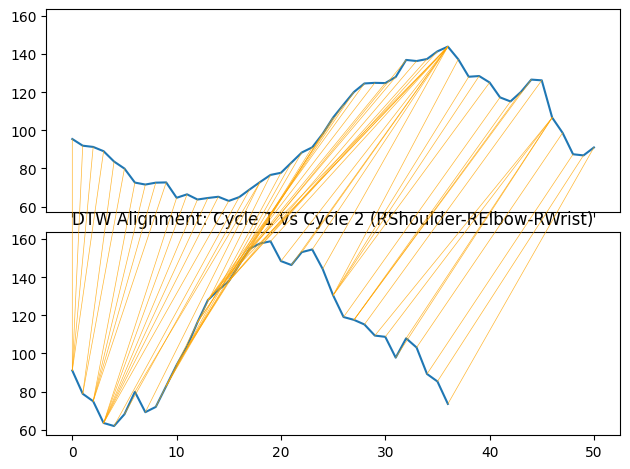

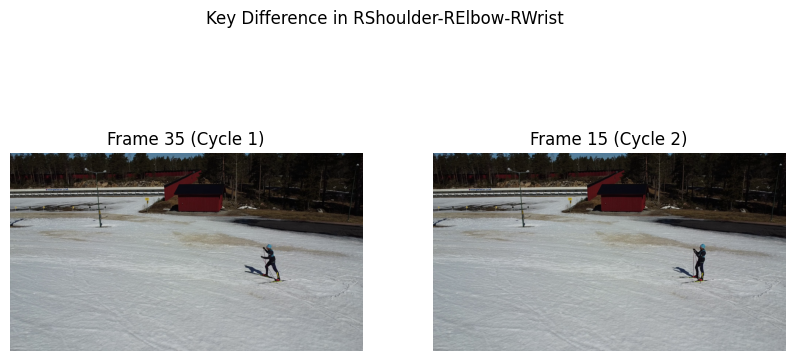

<Figure size 800x400 with 0 Axes>

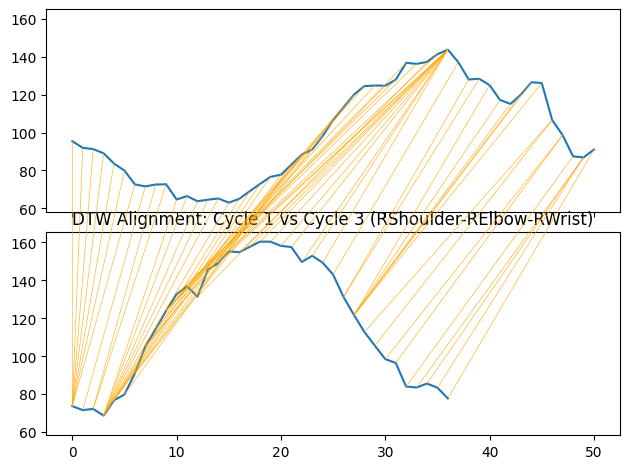

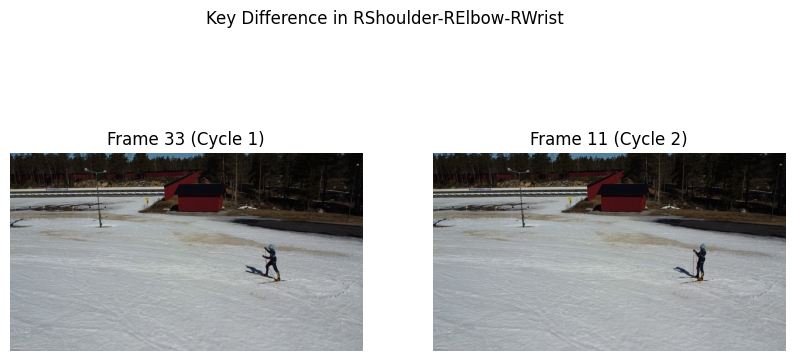

<Figure size 800x400 with 0 Axes>

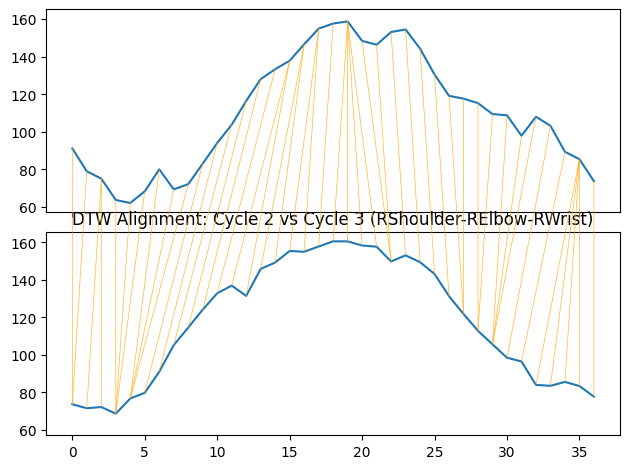

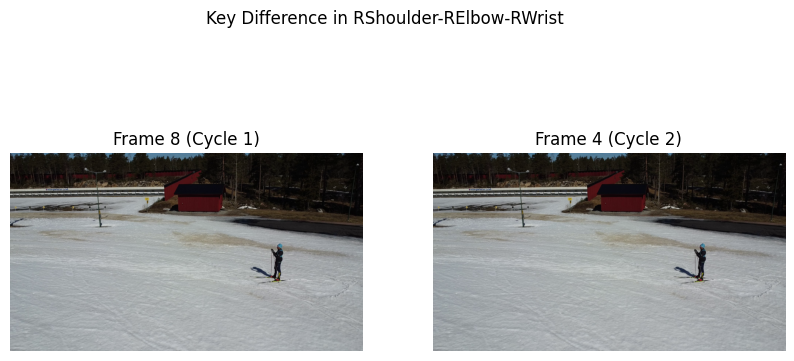

<Figure size 800x400 with 0 Axes>

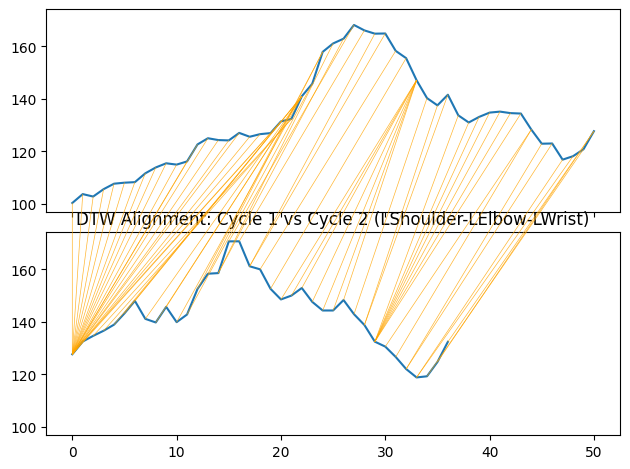

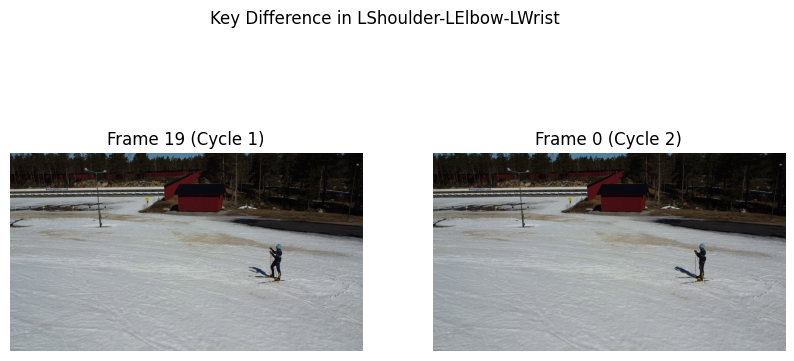

<Figure size 800x400 with 0 Axes>

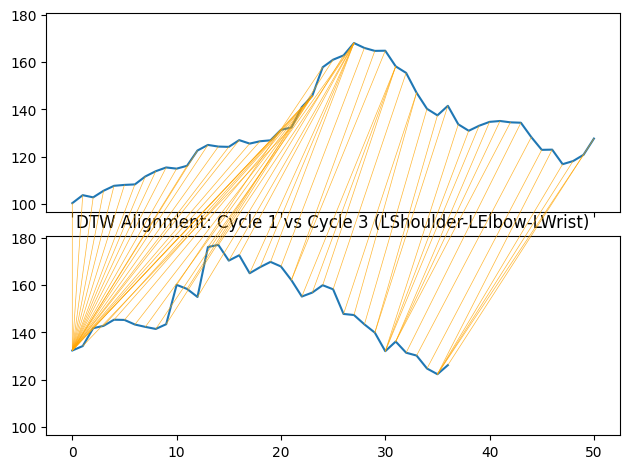

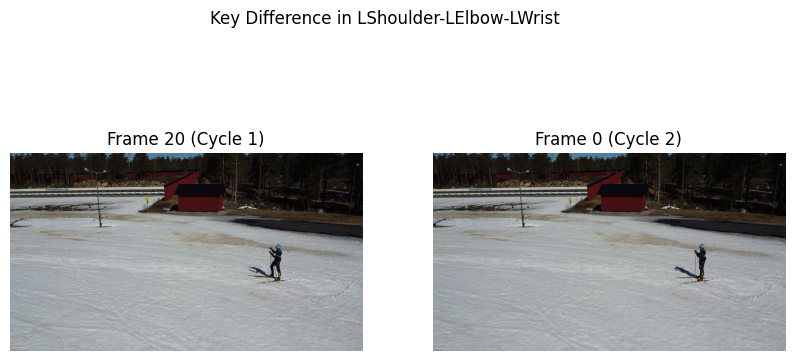

<Figure size 800x400 with 0 Axes>

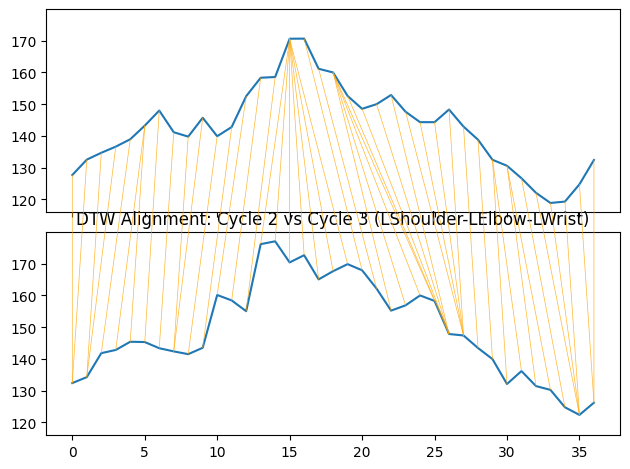

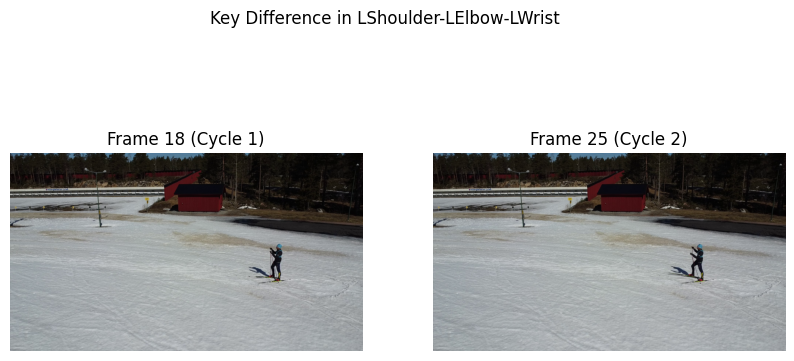

DTW Distance Cycle 1 vs Cycle 2 (RHip-RKnee-RAnkle): 23.04490413403837
DTW Distance Cycle 1 vs Cycle 3 (RHip-RKnee-RAnkle): 24.826548467737457
DTW Distance Cycle 2 vs Cycle 3 (RHip-RKnee-RAnkle): 19.028558370740598
DTW Distance Cycle 1 vs Cycle 2 (LHip-LKnee-LAnkle): 61.78998466290634
DTW Distance Cycle 1 vs Cycle 3 (LHip-LKnee-LAnkle): 72.89651729287007
DTW Distance Cycle 2 vs Cycle 3 (LHip-LKnee-LAnkle): 13.660364963252094
DTW Distance Cycle 1 vs Cycle 2 (RShoulder-RElbow-RWrist): 42.94899636975873
DTW Distance Cycle 1 vs Cycle 3 (RShoulder-RElbow-RWrist): 61.66817136130608
DTW Distance Cycle 2 vs Cycle 3 (RShoulder-RElbow-RWrist): 29.430494577330872
DTW Distance Cycle 1 vs Cycle 2 (LShoulder-LElbow-LWrist): 70.14075412335455
DTW Distance Cycle 1 vs Cycle 3 (LShoulder-LElbow-LWrist): 87.84086731447272
DTW Distance Cycle 2 vs Cycle 3 (LShoulder-LElbow-LWrist): 21.45024853685014


In [41]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_visualisation

def load_cycles(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def compute_angle(p1, p2, p3):
    """Computes the angle between three points."""
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(dot_product / norm_product) * (180.0 / np.pi)

def extract_angle_series(cycle_data, joint1, joint2, joint3):
    """Extracts time-series data for an angle between three joints from a cycle."""
    angles = []
    frames = []
    for i in range(len(cycle_data[joint1 + "_x"])):
        p1 = (cycle_data[joint1 + "_x"][i], cycle_data[joint1 + "_y"][i])
        p2 = (cycle_data[joint2 + "_x"][i], cycle_data[joint2 + "_y"][i])
        p3 = (cycle_data[joint3 + "_x"][i], cycle_data[joint3 + "_y"][i])
        angles.append(compute_angle(p1, p2, p3))
        frames.append(cycle_data["Start_frame"] + i)
    return np.array(angles), frames

def extract_frame(video_path, frame_idx):
    """Extracts and returns a specific frame from a video file."""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        return None

def plot_frame_differences(cycle1_data, cycle2_data, path, joint_triplet, video_path):
    """Plots frames with the largest differences based on DTW path and extracts video frames."""
    max_diff_idx = np.argmax([abs(i - j) for i, j in path])
    frame1, frame2 = path[max_diff_idx]
    
    frame1_img = extract_frame(video_path, frame1)
    frame2_img = extract_frame(video_path, frame2)
    
    if frame1_img is not None and frame2_img is not None:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(frame1_img)
        axs[0].set_title(f"Frame {frame1} (Cycle 1)")
        axs[0].axis("off")
        
        axs[1].imshow(frame2_img)
        axs[1].set_title(f"Frame {frame2} (Cycle 2)")
        axs[1].axis("off")
        
        plt.suptitle(f"Key Difference in {joint_triplet}")
        plt.show()

def compare_cycles_angles(data, joint_triplets, video_path, gear_filter=None, visualize=False):
    """Compares movement cycles for specific joint angles using DTW and optionally visualizes the alignment."""
    dtw_results = {}
    cycles = {k: v for k, v in data.items() if gear_filter is None or v.get("Label") == gear_filter}
    cycle_keys = list(cycles.keys())
    
    for joint1, joint2, joint3 in joint_triplets:
        for i in range(len(cycle_keys)):
            for j in range(i + 1, len(cycle_keys)):
                cycle1, frames1 = extract_angle_series(cycles[cycle_keys[i]], joint1, joint2, joint3)
                cycle2, frames2 = extract_angle_series(cycles[cycle_keys[j]], joint1, joint2, joint3)
                dist = dtw.distance(cycle1, cycle2)
                path = dtw.warping_path(cycle1, cycle2)
                dtw_results[f"{cycle_keys[i]} vs {cycle_keys[j]} ({joint1}-{joint2}-{joint3})"] = dist
                
                if visualize:
                    plt.figure(figsize=(8, 4))
                    dtw_visualisation.plot_warping(cycle1, cycle2, path, filename=None)
                    plt.title(f"DTW Alignment: {cycle_keys[i]} vs {cycle_keys[j]} ({joint1}-{joint2}-{joint3})")
                    plt.show()
                    
                    plot_frame_differences(cycle1, cycle2, path, f"{joint1}-{joint2}-{joint3}", video_path)
    
    return dtw_results

# Load cycle data
file_path = "../classification/cycle_splits/labeled_data/labeled_cycles_17_cut.json"
video_path = r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\selectedData\DJI_0017_cut.mp4"  # Path to the corresponding video file
data = load_cycles(file_path)

# Define joint triplets for angle comparisons
joint_triplets = [("RHip", "RKnee", "RAnkle"), ("LHip", "LKnee", "LAnkle"), ("RShoulder", "RElbow", "RWrist"), ("LShoulder", "LElbow", "LWrist")]

# Compare angles for cycles within the same gear with visualization
dtw_comparisons = compare_cycles_angles(data, joint_triplets, video_path, gear_filter="gear2", visualize=True)

# Print DTW results
for comparison, distance in dtw_comparisons.items():
    print(f"DTW Distance {comparison}: {distance}")


In [ ]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_visualisation

def load_cycles(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def compute_angle(p1, p2, p3):
    """Computes the angle between three points."""
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(dot_product / norm_product) * (180.0 / np.pi)

def extract_angle_series(cycle_data, joint1, joint2, joint3):
    """Extracts time-series data for an angle between three joints from a cycle."""
    angles = []
    frames = []
    for i in range(len(cycle_data[joint1 + "_x"])):
        p1 = (cycle_data[joint1 + "_x"][i], cycle_data[joint1 + "_y"][i])
        p2 = (cycle_data[joint2 + "_x"][i], cycle_data[joint2 + "_y"][i])
        p3 = (cycle_data[joint3 + "_x"][i], cycle_data[joint3 + "_y"][i])
        angles.append(compute_angle(p1, p2, p3))
        frames.append(i)
    return np.array(angles), frames

def extract_frame(video_path, frame_idx):
    """Extracts and returns a specific frame from a video file."""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        return None

def overlay_frames(frame1, frame2, alpha=0.5):
    """Overlays two frames with transparency."""
    if frame1.shape != frame2.shape:
        frame2 = cv2.resize(frame2, (frame1.shape[1], frame1.shape[0]))
    blended = cv2.addWeighted(frame1, alpha, frame2, 1 - alpha, 0)
    return blended

#TODO
def plot_overlaid_frames(video_path, path):
    """Extracts and overlays frames based on DTW alignment."""
    if not path:
        print("No frames to overlay.")
        return
    
    num_frames = min(len(path), 6)  # Ensure at most 6 subplots
    sampled_indices = np.linspace(0, len(path) - 1, num_frames, dtype=int)
    
    fig, axs = plt.subplots(1, num_frames, figsize=(15, 5))
    axs = np.atleast_1d(axs)  # Ensure axs is iterable
    
    for idx, sample_idx in enumerate(sampled_indices[:len(axs)]):
        frame1, frame2 = path[sample_idx]
        f1 = extract_frame(video_path, frame1)
        f2 = extract_frame(video_path, frame2)
        if f1 is not None and f2 is not None:
            overlay = overlay_frames(f1, f2)
            axs[idx].imshow(overlay)
            axs[idx].set_title(f"Frames {frame1} & {frame2}")
            axs[idx].axis("off")
    
    plt.suptitle("Overlaid Frames Aligned by DTW")
    plt.show()

def compare_cycles_angles(data, joint_triplets, video_path, gear_filter=None, visualize=False):
    """Compares movement cycles for specific joint angles using DTW and optionally visualizes the alignment."""
    dtw_results = {}
    cycles = {k: v for k, v in data.items() if gear_filter is None or v.get("Label") == gear_filter}
    cycle_keys = list(cycles.keys())
    
    for joint1, joint2, joint3 in joint_triplets:
        for i in range(len(cycle_keys)):
            for j in range(i + 1, len(cycle_keys)):
                cycle1, frames1 = extract_angle_series(cycles[cycle_keys[i]], joint1, joint2, joint3)
                cycle2, frames2 = extract_angle_series(cycles[cycle_keys[j]], joint1, joint2, joint3)
                dist = dtw.distance(cycle1, cycle2)
                path = dtw.warping_path(cycle1, cycle2)
                dtw_results[f"{cycle_keys[i]} vs {cycle_keys[j]} ({joint1}-{joint2}-{joint3})"] = dist
                
                if visualize:
                    plt.figure(figsize=(8, 4))
                    dtw_visualisation.plot_warping(cycle1, cycle2, path, filename=None)
                    plt.title(f"DTW Alignment: {cycle_keys[i]} vs {cycle_keys[j]} ({joint1}-{joint2}-{joint3})")
                    plt.show()
                    
                    plot_overlaid_frames(video_path, path)
    
    return dtw_results

# Load cycle data
file_path = "../classification/cycle_splits/labeled_data/labeled_cycles_17_cut.json"
video_path = r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\selectedData\DJI_0017_cut.mp4"  # Path to the corresponding video file
data = load_cycles(file_path)

# Define joint triplets for angle comparisons
joint_triplets = [("RHip", "RKnee", "RAnkle"), ("LHip", "LKnee", "LAnkle"), ("RShoulder", "RElbow", "RWrist"), ("LShoulder", "LElbow", "LWrist")]

# Compare angles for cycles within the same gear with visualization
dtw_comparisons = compare_cycles_angles(data, joint_triplets, video_path, gear_filter=None, visualize=True)

# Print DTW results
for comparison, distance in dtw_comparisons.items():
    print(f"DTW Distance {comparison}: {distance}")

In [ ]:
file_path_1 = "../classification/cycle_splits/labeled_data/labeled_cycles_11.json"
file_path_2 = "../classification/cycle_splits/labeled_data/labeled_cycles_38.json"

In [52]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_visualisation

def load_cycles(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def compute_angle(p1, p2, p3):
    """Computes the angle between three points."""
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(dot_product / norm_product) * (180.0 / np.pi)

def extract_angle_series(cycle_data, joint1, joint2, joint3):
    """Extracts time-series data for an angle between three joints from a cycle."""
    angles = []
    frames = []
    for i in range(len(cycle_data[joint1 + "_x"])):
        p1 = (cycle_data[joint1 + "_x"][i], cycle_data[joint1 + "_y"][i])
        p2 = (cycle_data[joint2 + "_x"][i], cycle_data[joint2 + "_y"][i])
        p3 = (cycle_data[joint3 + "_x"][i], cycle_data[joint3 + "_y"][i])
        angles.append(compute_angle(p1, p2, p3))
        frames.append(i)
    return np.array(angles), frames

# function to extract several angles at once
def extract_multivariate_series(cycle_data, joint_triplets):
    """Extracts multivariate time-series data for multiple angles from a cycle."""
    all_angles = []
    frames = []
    for i in range(len(cycle_data[joint_triplets[0][0] + "_x"])):
        angles = []
        for joint1, joint2, joint3 in joint_triplets:
            p1 = (cycle_data[joint1 + "_x"][i], cycle_data[joint1 + "_y"][i])
            p2 = (cycle_data[joint2 + "_x"][i], cycle_data[joint2 + "_y"][i])
            p3 = (cycle_data[joint3 + "_x"][i], cycle_data[joint3 + "_y"][i])
            angles.append(compute_angle(p1, p2, p3))
        all_angles.append(angles)
        frames.append(i)
    return np.array(all_angles), frames

def extract_frame(video_path, frame_idx):
    """Extracts and returns a specific frame from a video file."""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        return None

def overlay_frames_loop(video_path, path, cycle1_start_frame, cycle2_start_frame, series1, series2):
    """Overlays frames one by one with OpenCV and displays frame numbers."""
    if not path:
        print("No frames to overlay.")
        return
    
    for frame1, frame2 in path:

        f1 = extract_frame(video_path, frame1 + cycle1_start_frame)
        f2 = extract_frame(video_path, frame2 + cycle2_start_frame)
        if f1 is not None and f2 is not None:
            overlay = cv2.addWeighted(f1, 0.5, f2, 0.5, 0)
            overlay = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
            
            cv2.putText(overlay, f"Frame 1: {frame1}, angle: {series1[frame1]}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(overlay, f"Frame 2: {frame2}, angle: {series2[frame2]}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow("Overlayed Frames", overlay)
            
            if cv2.waitKey(0) & 0xFF == ord('q'):
                break
    
    cv2.destroyAllWindows()

def compare_selected_cycles(data, joint_triplets, video_path, cycle1_key, cycle2_key, visualize=False):
    """Compares two selected movement cycles using DTW and optionally visualizes the alignment."""
    cycle1 = data.get(cycle1_key)
    cycle1_start_frame = cycle1.get("Start_frame")
    cycle2 = data.get(cycle2_key)
    cycle2_start_frame = cycle2.get("Start_frame")
    if not cycle1 or not cycle2:
        print("One or both selected cycles not found.")
        return {}
    
    dtw_results = {}
    
    # testing multivariate DTW
    series1_multi, frames1_multi = extract_multivariate_series(cycle1, joint_triplets)
    series2_multi, frames2_multi = extract_multivariate_series(cycle2, joint_triplets)
    
    print(f"Multi dim = {series1_multi.shape}")
    print(f"Flattend: {series1_multi.flatten().shape}")
    
    settings = dtw.DTWSettings(use_ndim=True)
    dist, path = dtw.warping_paths(series1_multi, series2_multi, use_ndim=True)
    
    dtw_results = {f"{cycle1_key} vs {cycle2_key} (Multivariate DTW)": dist}
    
    # if visualize:
    #     plt.figure(figsize=(8, 4))
    #     plt.plot(range(len(frame_distances)), frame_distances, label="Multivariate DTW Distances")
    #     plt.xlabel("Time Step")
    #     plt.ylabel("DTW Distance")
    #     plt.title(f"Frame-wise Multivariate DTW Distances: {cycle1_key} vs {cycle2_key}")
    #     plt.legend()
    #     plt.show()
        
    # for joint1, joint2, joint3 in joint_triplets:
    #     # series is an array with all the angles
    #     series1, frames1 = extract_angle_series(cycle1, joint1, joint2, joint3)
    #     series2, frames2 = extract_angle_series(cycle2, joint1, joint2, joint3)
    #     # as I understand it this is the distance for the full signal => we could maybe have like a few expert cycles that are a little different
    #     # then choose the cycle we want to use for giving feedback based on that distance
    #     dist = dtw.distance(series1, series2)
    #     # path is an array of tuples showing which frames are being matched together. They start with 0 though so the start frame needs to be added 
    #     # to this!
    #     path = dtw.warping_path(series1, series2)
    #     # here we save the results per joint
    #     dtw_results[f"{cycle1_key} vs {cycle2_key} ({joint1}-{joint2}-{joint3})"] = dist
        
    if visualize:
        plt.figure(figsize=(8, 4))
        dtw_visualisation.plot_warping(series1_multi, series2_multi, path, use_ndim = True, filename=None)
        plt.title(f"DTW Alignment: {cycle1_key} vs {cycle2_key} ({joint_triplets[0]}-{joint_triplets[1]}-{joint_triplets[2]})")
        plt.show()
        
        overlay_frames_loop(video_path, path, cycle1_start_frame, cycle2_start_frame, series1_multi, series2_multi)
    
    return dtw_results

# Load cycle data
file_path = "../classification/cycle_splits/labeled_data/labeled_cycles_17_cut.json"
video_path = r"C:\awilde\britta\LTU\SkiingProject\SkiersProject\Data\selectedData\DJI_0017_cut.mp4"  # Path to the corresponding video file
data = load_cycles(file_path)

# Define joint triplets for angle comparisons
joint_triplets = [("RHip", "RKnee", "RAnkle"), ("LHip", "LKnee", "LAnkle"), ("RShoulder", "RElbow", "RWrist"), ("LShoulder", "LElbow", "LWrist")]
#joint_triplets = [("RHip", "RKnee", "RAnkle")]

# User selects which cycles to compare
cycle1_key = input("Enter the first cycle key: ")
cycle2_key = input("Enter the second cycle key: ")

# Compare selected cycles
dtw_comparisons = compare_selected_cycles(data, joint_triplets, video_path, cycle1_key, cycle2_key, visualize=True)

# Print DTW results
for comparison, distance in dtw_comparisons.items():
    print(f"DTW Distance {comparison}: {distance}")


Multi dim = (37, 4)
Flattend: (148,)


TypeError: plot_warping() got an unexpected keyword argument 'use_ndim'

<Figure size 800x400 with 0 Axes>